# Step 1: Data Preprocessing and EDA

In [1]:
# Import libraries
import re
import json
import string
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
# CONSTANTS
UNKNOWN_GENRE = ('Unknown',)
UNKNOWN_AUTHOR = 'Unknown'

## Load dataset

In [3]:
# header for dataset
header = ['Wikipedia article ID', 'Freebase ID', 'Book title', 'Author',
          'Publication date', 'Book genres (Freebase ID:name tuples)',
          'Plot summary']

# Load dataset from text file
data = pd.read_csv('booksummaries.txt', sep='\t', header=None,
                   names=header, encoding='utf-8')

In [4]:
# Display sample of data
data.head()

,Wikipedia article ID,Freebase ID,Book title,Author,Publication date,Book genres (Freebase ID:name tuples),Plot summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [5]:
# Display shape of data
print(f"Shape of dataset: {data.shape}")

Shape of dataset: (16559, 7)


## Preprocess Section

In [6]:
# # Drop "Freebase ID" column cuase that values are unique and useless
data = data.drop("Wikipedia article ID", axis=1)
data = data.drop("Freebase ID", axis=1)

# Add "Index" column by reset it
data = data.reset_index()
data.rename(columns={'index': 'Index'}, inplace=True)

In [7]:
# convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_dict = json.loads(data.loc[i, 'Book genres (Freebase ID:name tuples)'])
        if isinstance(genres_dict, dict):
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = tuple(genres_dict.values())
        else:
            data.at[i, 'Book genres (Freebase ID:name tuples)'] = np.nan
    except (TypeError, json.JSONDecodeError):  # Handle NaN values and JSON decoding errors
        continue

data.rename(columns={'Book genres (Freebase ID:name tuples)': 'Book genres'}, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 16559/16559 [00:01<00:00, 15223.05it/s]


In [8]:
def extract_year(pub_date):
    """
    Convert publication date to just the year
    (if it's in YYYY-MM-DD format)
    """
    if isinstance(pub_date, str) and '-' in pub_date:
        return pd.to_datetime(pub_date, errors='coerce').year
    return int(pub_date) if isinstance(pub_date, str) and pub_date.isdigit()\
        else np.nan

data['Publication year'] = data['Publication date'].apply(extract_year)

In [9]:
# Remove duplicate rows
# Check for duplicates based on a unique identifier or key columns
duplicates = data.duplicated(subset=['Book title', 'Author'], keep='first')
print(f"Number of duplicate rows: {duplicates.sum()}")

# # Drop duplicates
data = data.drop_duplicates(subset=['Book title', 'Author'], keep='first')

Number of duplicate rows: 8


In [10]:
# text cleaning
# if get an error for this line, you must use `nltk.download()`
# command and download stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Remove extra  before and after whitespace
    text = text.strip()
    # check if text is none
    text = text if text else np.nan

    return text

data['Cleaned Summary'] = data['Plot summary'].apply(clean_text)

In [11]:
# Drop rows where 'Cleaned Summary' is NaN
data = data.dropna(subset=['Cleaned Summary'])

In [12]:
# summary length
data['Summary Length'] = data['Cleaned Summary']\
    .apply(lambda x: len(x.split()))

# Detect outliers in Summary_Length
Q1 = data['Summary Length'].quantile(0.25)
Q3 = data['Summary Length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Summary Length'] < lower_bound) |
                (data['Summary Length'] > upper_bound)]
print(f"Number of outliers in Summary Length: {outliers.shape[0]}")

# Remove outliers
data = data[(data['Summary Length'] >= lower_bound) &
            (data['Summary Length'] <= upper_bound)]

Number of outliers in Summary Length: 953


In [13]:
# Fill Author missing values with UNKNOWN_AUTHOR variable because
# We cannot put anyone's book under the name of another author
data['Author'].fillna(UNKNOWN_AUTHOR, inplace=True)

In [14]:
# Fill missing values book generes based of other author's book
# this section of code is not good and fix just 2 rows:)))


def fill_missing_genres(df, num_modes):
    for author, group in tqdm(df.groupby('Author')):
        if author != UNKNOWN_AUTHOR:
            genres = [genre for genres in group['Book genres'] if
                      isinstance(genres, tuple) for genre in genres]
            if genres:
                mode_genres = [genre for genre, _ in Counter(genres)
                               .most_common(num_modes)]
                # We do this because normaly can't assign tuple
                # and we get an error
                if len(df.loc[(df['Author'] == author) &
                       (df['Book genres'].isnull()), 'Book genres']) > 0:
                    for i in data.loc[(data['Author'] == 'Aaron Allston') &
                                      (data['Book genres'].isnull()),
                                      'Index'].values:
                        df.at[i, 'Book genres'] = tuple(mode_genres)

    return df


# Fill missing genres based on author with the 5 most common genres
data = fill_missing_genres(data, 5)

100%|██████████████████████████████████████████████████████████████████████████████████████| 4553/4553 [00:13<00:00, 346.72it/s]


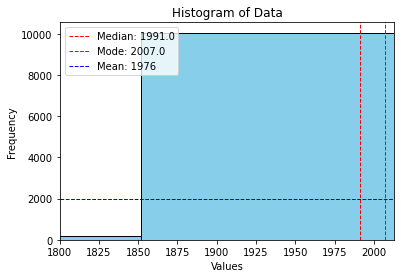

In [15]:
# Plot a histogram to find out median is better for 'Publication year' or mode
median = data['Publication year'].median()
mode = data['Publication year'].mode()[0]
mean = int(data['Publication year'].mean())

plt.hist(data['Publication year'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add markers for median and mode
plt.axvline(median, color='r', linestyle='dashed',
            linewidth=1, label=f'Median: {median}')
plt.axvline(mode, color='g', linestyle='dashed',
            linewidth=1, label=f'Mode: {mode}')
plt.axhline(mean, color='b', linestyle='dashed',
            linewidth=1, label=f'Mean: {mean}')
plt.xlim(1800, data['Publication year'].max())

plt.legend()
plt.show()

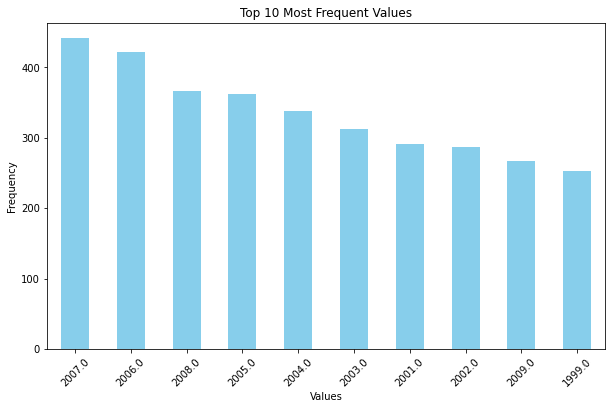

In [16]:
# Calculate the frequency of each value
value_counts = data['Publication year'].value_counts()

# Get the top 10 most frequent values
top_values = value_counts.head(10)

# Plot a bar plot for the top 10 most frequent values
plt.figure(figsize=(10, 6))
top_values.plot(kind='bar', color='skyblue')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Values')
plt.xticks(rotation=45)
plt.show()

In [17]:
# fill Publication Year and Publication date missing value
# with mode of data based on Top 10 values plot
mean_year = int(data['Publication year'].mode()[0])
data['Publication year'].fillna(mean_year, inplace=True)
data['Publication date'].fillna(mean_year, inplace=True)

In [18]:
# We can use "Title-Based" method or Pre-Trained NLP Model
# for Genre Prediction but in this step ignore this method
# and just set this missing value genre with UNKNOWN_GENRE variable


def fill_with_unknown_genre(x):
    return UNKNOWN_GENRE if pd.isnull(x) else x


data['Book genres'] = data['Book genres'].apply(fill_with_unknown_genre)

In [19]:
# Check the Nan value of all columns
print(data.isna().sum())

Index               0
Book title          0
Author              0
Publication date    0
Book genres         0
Plot summary        0
Publication year    0
Cleaned Summary     0
Summary Length      0
dtype: int64


In [20]:
# save cleaned data
data.to_csv('cleaned_book_summary.csv', sep='\t',
            index=False, encoding='utf-8')

## EDA section

In [21]:
import ast
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Load dataset from csv file
data = pd.read_csv('cleaned_book_summary.csv', sep='\t', encoding='utf-8')

In [23]:
# convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_tuple = ast.literal_eval(data.loc[i, 'Book genres'])
        if isinstance(genres_tuple, tuple):
            data.at[i, 'Book genres'] = genres_tuple
        else:
            data.at[i, 'Book genres'] = np.nan
    except (SyntaxError, ValueError):
        continue

100%|██████████████████████████████████████████████████████████████████████████████████| 15593/15593 [00:01<00:00, 10041.61it/s]


In [24]:
def get_genres_distribution(df):
    """
    Calculate the distribution of book genres in the provided DataFrame.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing a column 'Book genres'
    with lists of genres for each book.

    Returns:
    pandas.Series: A Series object containing the count of each genre across
    all books in descending order.

    The function iterates through the 'Book genres' column of the DataFrame 
    and counts the occurrences of each genre.
    It then sorts the genres_counts dictionary by the count of each genre in 
    descending order. The sorted dictionary is converted into a Pandas Series
    and returned.
    """
    genres_counts = dict()
    for i, genres in enumerate(df['Book genres']):
        for genre in genres:
            genres_counts[genre] = genres_counts.get(genre, 0) + 1

    # Sort the genres_counts dictionary by values in descending order
    sorted_genres_counts = dict(sorted(genres_counts.items(), 
                                       key=lambda item: item[1],
                                       reverse=True))

    # Convert the sorted dictionary to a Pandas Series
    genre_series = pd.Series(sorted_genres_counts)
    
    return genre_series

In [25]:
# Get basic information about data
print(f"Number of books: {data.shape[0]}")
# Check for any remaining missing values
print(f"Missing values: {data.isnull().sum().any()}")

Number of books: 15593
Missing values: False



Summary length statistics:
count    15593.000000
mean       184.366575
std        155.291544
min          1.000000
25%         63.000000
50%        130.000000
75%        268.000000
max        668.000000
Name: Summary Length, dtype: float64


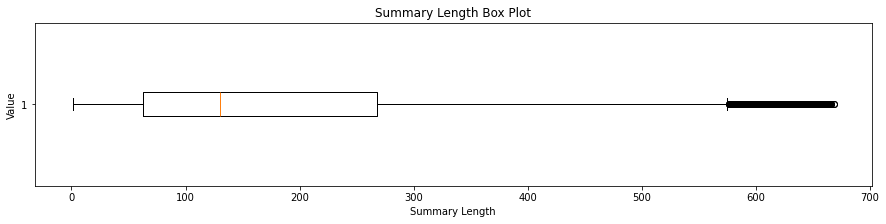

In [26]:
# Analyze summary length
summary_stats = data['Summary Length'].describe()
print(f"\nSummary length statistics:\n{summary_stats}")

# box plot for summary length
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Summary Length'], vert=False)
plt.title('Summary Length Box Plot')
plt.xlabel('Summary Length')
plt.ylabel('Value')
plt.show()


Publication year statistics:
count    15593.000000
mean      1986.779581
std         42.171144
min        398.000000
25%       1982.000000
50%       2004.000000
75%       2007.000000
max       2013.000000
Name: Publication year, dtype: float64


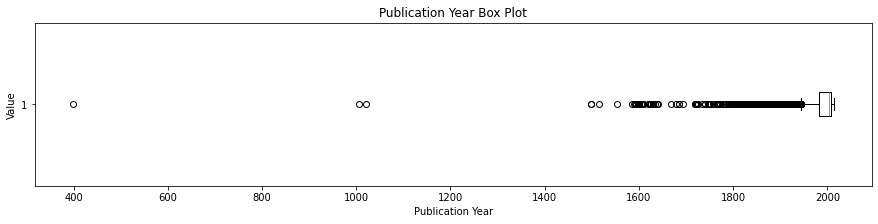

In [27]:
# Analyze publication year
publication_stats = data['Publication year'].describe()
print(f"\nPublication year statistics:\n{publication_stats}")

# box plot for publication year
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Publication year'], vert=False)
plt.title('Publication Year Box Plot')
plt.xlabel('Publication Year')
plt.ylabel('Value')
plt.show()


Genre distribution:
Fiction                4401
Speculative fiction    3995
Unknown                3552
Science Fiction        2675
Novel                  2312
                       ... 
Popular culture           1
Neuroscience              1
Alien invasion            1
Comedy of manners         1
Pastiche                  1
Length: 223, dtype: int64


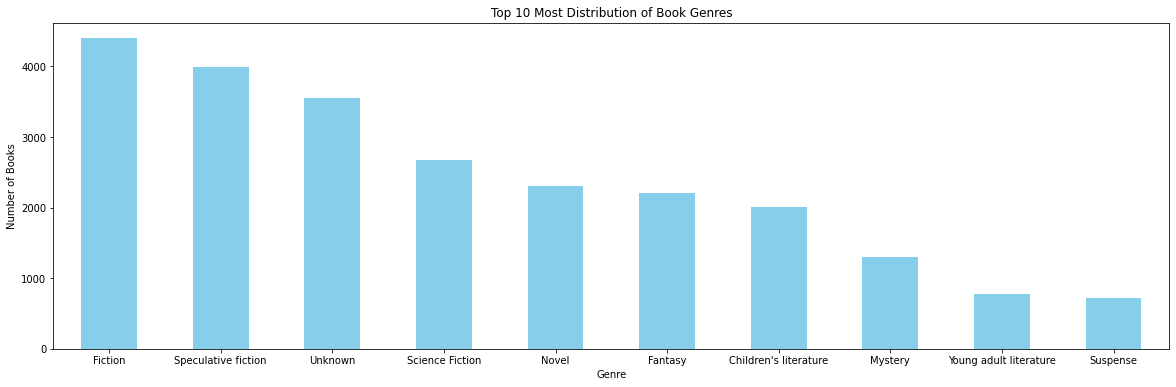

In [28]:
# Genre distribution
genre_counts = get_genres_distribution(data)
print(f"\nGenre distribution:\n{genre_counts}")

# Get the top 10 most frequent genres
top_genres = genre_counts.head(10)

# Plot genre distribution
plt.figure(figsize=(20, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.title('Top 10 Most Distribution of Book Genres')
plt.xticks(rotation=0)
plt.show()


Publication year distribution:

Publication year
2007.0    5756
2006.0     422
2008.0     366
2005.0     362
2004.0     338
          ... 
1590.0       1
1768.0       1
1621.0       1
1516.0       1
1640.0       1
Name: count, Length: 264, dtype: int64


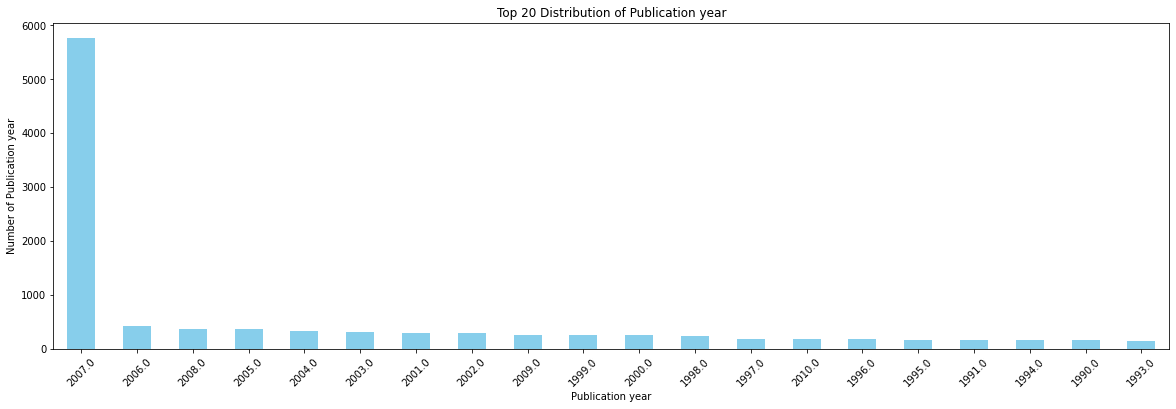

In [29]:
# Publication year distribution
year_counts = data['Publication year'].value_counts()
print(f"\nPublication year distribution:\n\n{year_counts}")

# Get the top 20 most frequent publication year
top_years = year_counts.head(20)

# Plot publication year distribution
plt.figure(figsize=(20, 6))
top_years.plot(kind='bar', color='skyblue')
plt.xlabel("Publication year")
plt.ylabel("Number of Publication year")
plt.title("Top 20 Distribution of Publication year")
plt.xticks(rotation=45)
plt.show()


Author analysis:

Author
Unknown                 2294
Franklin W. Dixon         67
K. A. Applegate           60
Agatha Christie           58
Edgar Rice Burroughs      57
                        ... 
Mary Cheney                1
Nick Enright               1
Sion Sono                  1
Ntozake Shange             1
Stephen Colbert            1
Name: count, Length: 4553, dtype: int64


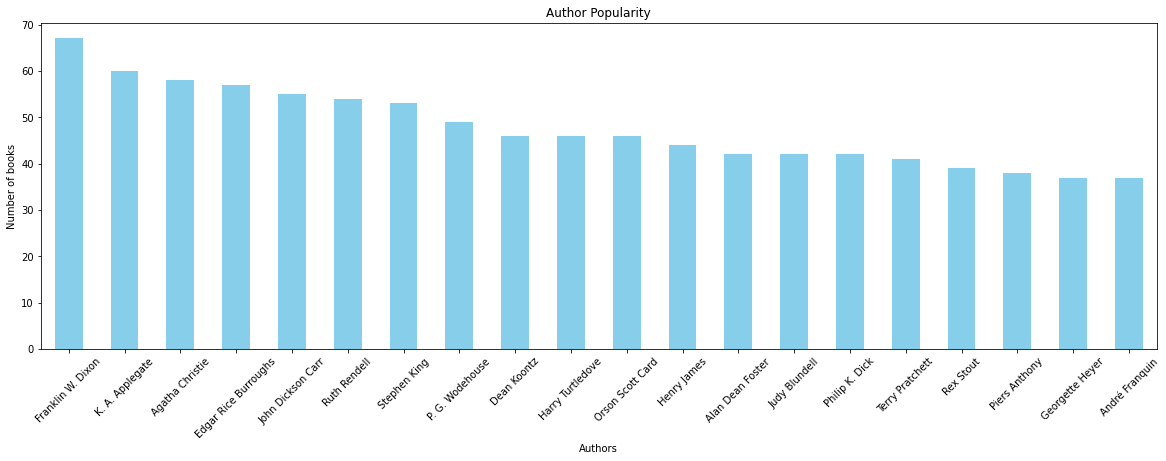

In [30]:
# Author analysis
author_counts = data['Author'].value_counts()
print(f"\nAuthor analysis:\n\n{author_counts}")

# Get the top 20 most frequent authors
top_authors = author_counts.head(21)[1:]  # remove the Unknown author

# Plot most frequent authors
plt.figure(figsize=(20, 6))
top_authors.plot(kind='bar', color='skyblue')
plt.xlabel("Authors")
plt.ylabel("Number of books")
plt.title("Author Popularity")
plt.xticks(rotation=45)
plt.show()

(Science Fiction, Speculative fiction)    1860
(Speculative fiction, Fiction)            1829
(Speculative fiction, Fantasy)            1186
(Children's literature, Fiction)          1037
(Science Fiction, Fiction)                1001
(Fantasy, Fiction)                         941
(Mystery, Fiction)                         802
(Fiction, Novel)                           745
(Fiction, Suspense)                        620
(Mystery, Suspense)                        613
Name: count, dtype: int64


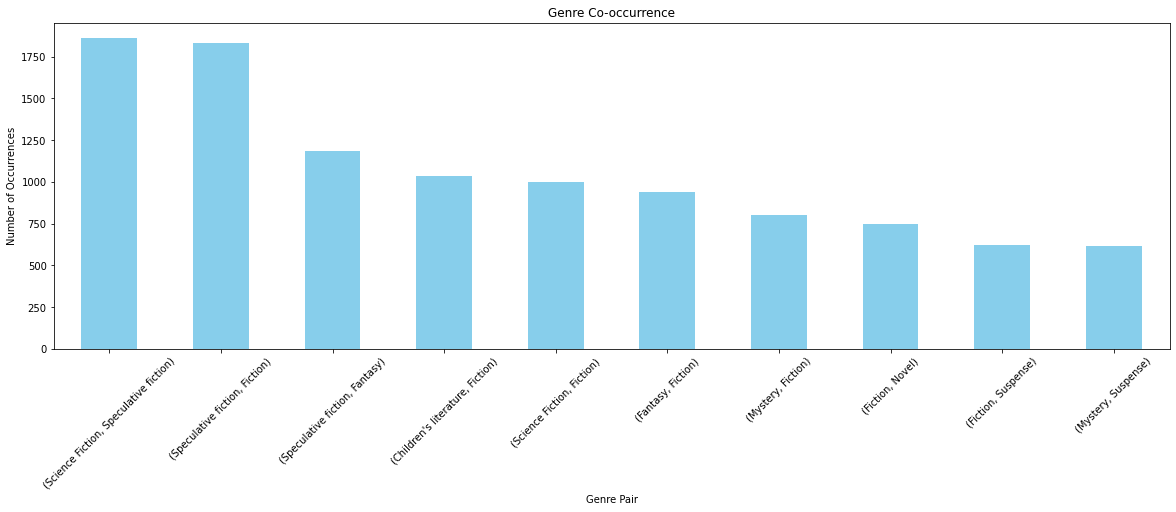

In [31]:
# Genre Co-occurrence analysis
genre_pairs = []
for genres in data['Book genres']:
    for i in range(len(genres) - 1):
        for j in range(i + 1, len(genres)):
            pair = (genres[i], genres[j])
            genre_pairs.append(pair)

# Count occurrences
genre_pair_counts = pd.Series(genre_pairs).value_counts()

# Print top 10 most frequent genre pairs
most_frequent_genre_pairs = genre_pair_counts.head(10)
print(most_frequent_genre_pairs)

# Plot most frequent genre co-occurrence
plt.figure(figsize=(20, 6))
most_frequent_genre_pairs.plot(kind='bar', color='skyblue')
plt.xlabel("Genre Pair")
plt.ylabel("Number of Occurrences")
plt.title("Genre Co-occurrence")
plt.xticks(rotation=45)
plt.show()